IMRT Beam Angle Optimization
==
Usando como base el solver `DAO_ILS`, la idea es crear un algoritmo que permita encontrar los mejores ángulos para realizar el tratamiento.

---
**Carga de librerías y conexión SSH**

In [1]:
import paramiko
import getpass
import numpy as np
import imrt

In [2]:
ssh = imrt.connect("158.251.88.197")

login: iaraya
pass: ········


----
Constructor imrt
---

Se carga la instancia remotamente generando las estructuras necesarias para ser usada. `max_voxels` es la cantidad máxima de voxels que se usa para representar un órgano. Limitar la cantidad permite probar los algoritmos más rápidamente.

Además carga localmente información de las instancias:

* cantidad de voxels por órgano (`nvoxels`)
* lista de ángulos (`angles`)
* cantidad de beamlets y valid shapes por ángulos (`angle2nbeamlets`)

In [3]:
instance = imrt.imrt("/home/iaraya/imrt", ["data/Equidistantes/equidist.txt", "data/Equidistantes/equidist-coord.txt"], ssh, max_voxels=500, port=8051)

killall DAO_ILS; /home/iaraya/imrt/DAO_ILS --files-dep=data/Equidistantes/equidist.txt --file-coord=data/Equidistantes/equidist-coord.txt --tabu-size=200 --seed=3 --min_impr=0.05 --maxeval=1000 --vsize=0.002 --max_voxels=500 --path=/home/iaraya/imrt --port=8051
echo start | netcat localhost 8051
ready



----
init_fluence_map
--

Carga el fluence map con el BAC (beam angle configuration) asociado.
Retorna la evaluación correspondiente.

In [31]:
instance.init_fluence_map(fluence_map=[], bac=[0, 175, 245, 315])

echo init_fluence_map 4 0 175 245 315  | netcat localhost 8051


28880.0

----
iterated_local_search (`DAO_ILS`)
---

Realiza una búsqueda local usando dos vecindarios y retorna la evaluación de la solución encontrada (y la cantidad de iteraciones realizada). Usa los siguientes tipos de movimiento:

* *beam_intensity move*: modifica un beamlet de un fluence map matrix (existe la opción *targeted* para ordenar los movimientos)
* *level_intensity move*: modifica un nivel de intensidad de la matriz

In [32]:
instance.iterated_local_search(maxeval=1000)

(122.699, 1000)

----
get_fluence_map
--
Retorna la solución del problema (fluence map vector)

In [36]:
fm = instance.get_fluence_map()
fm[0]

array([9, 7, 0, 9, 9, 9, 6, 6, 0, 6, 9, 9, 9, 9, 9, 9, 0, 0, 8, 9, 9, 9,
       9, 9, 9, 9, 5, 7, 8, 9, 9, 9, 9, 9, 6, 5, 7, 9, 9, 9, 9, 9, 9, 9,
       0, 8, 9, 9, 9, 9, 9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 8, 5, 9, 9, 9, 6,
       5, 0, 7, 0])

----
fm2matrix
--

Obtiene la matriz de intensidades de un ángulo a partir del *fluence map vector*.

In [37]:
Y = instance.fm2matrix(fm[0], 0)

En el siguiente ejemplo se grafica la matriz de intensidades para cada ángulo en el bac.

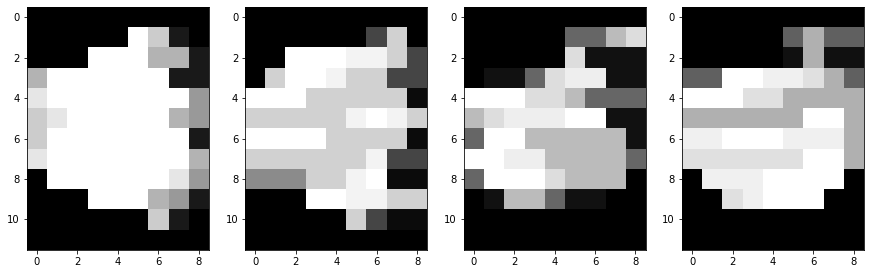

In [38]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image as im 

%matplotlib inline
fig=plt.figure(figsize=(15, 10))

i=1
for angle in instance.bac:
    array = instance.fm2matrix(fm[i-1],angle)
    fig.add_subplot(1, len(instance.bac), i)
    plt.imshow(array,cmap='gray')
    i += 1

plt.show()

----
get_dose_vectors
--

Retorna un vector de dosis irradiada a cada órgano por la solución (fluence map) actual.

In [39]:
dose_vectors = instance.get_dose_vectors()
for v in dose_vectors:
    print(v.shape)

(500,)
(500,)
(500,)


Aquí obtenemos un gráfico que muestra la proporción de voxels (y) que recibe al menos una dosis x.
Dosis prescrita para el tumor: 76 
Dosis recomendada para los órganos: menos a 65

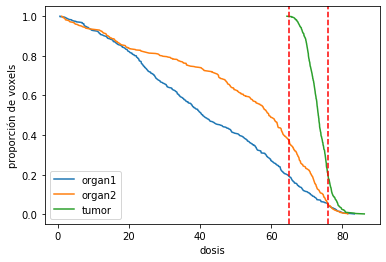

In [40]:
dose_vectors[0][::-1].sort()
index0 = (np.arange(len(dose_vectors[0]))+1)/len(dose_vectors[0])
dose_vectors[1][::-1].sort()
index1 = (np.arange(len(dose_vectors[1]))+1)/len(dose_vectors[1])
dose_vectors[2][::-1].sort()
index2 = (np.arange(len(dose_vectors[2]))+1)/len(dose_vectors[2])
plt.xlabel('dosis')
plt.ylabel('proporción de voxels')
plt.plot(dose_vectors[0], index0, '-' , dose_vectors[1], index1, '-' ,dose_vectors[2], index2, '-')
plt.axvline(x=65, color='r', linestyle='--')
plt.axvline(x=76, color='r', linestyle='--')
plt.legend(['organ1', 'organ2', 'tumor'], loc='best')

Indicadores clínicos
----

- $D_{x}$: Dosis recibida por el x% del tumor/órgano
- $D_{max}$: Máxima dosis recibida por el tumor/órgano
- $D_{mean}$: Dosis promedio recibida por el tumor/órgano
- $V_{x}$: Voxels que reciben al menos x% de la dosis

In [41]:
def D(dose_vector, x=95): return dose_vector[int(len(dose_vector)*x/100)]
def Dmax(dose_vector): return np.max(dose_vector)
def Dmean(dose_vector): return np.mean(dose_vector)
def V(dose_vector, dose=0.95*76): return np.argmax(dose_vector < dose)/len(dose_vector)

print("D_95 (tumor): ", D(dose_vectors[2],x=95))
print("Dmax (organ1): ", Dmax(dose_vectors[0]))
print("Dmean (organ2): ", Dmean(dose_vectors[1]))
print("V_95 (tumor): ", V(dose_vectors[2], dose=0.99*76))

D_95 (tumor):  68.023
Dmax (organ1):  83.3628
Dmean (organ2):  51.5255664
V_95 (tumor):  0.288


---
Otras funcionalidades
---

**matrix2fm**

Pasa una matrix a fluence_map asociado a un ángulo.

Note que si el angulo es distinto al original, el resultado puede no ser válido.

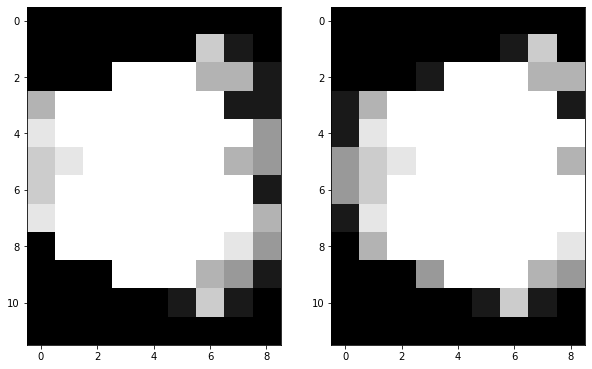

In [45]:
fig=plt.figure(figsize=(10, 10))


Y = instance.fm2matrix(fm[0],5)
fig.add_subplot(1, 2, 1)
plt.imshow(array,cmap='gray')

fm_new = instance.matrix2fm(Y, 0) # ángulo original es 0 y cambió a 5
fm[0] = fm_new
array = instance.fm2matrix(fm_new,5)
fig.add_subplot(1, 2, 2)
plt.imshow(array,cmap='gray')

plt.show()

Para llamar a la función `init_fluence_map` con una lista de fluence maps, tenemos que concatenarlas así `np.concatenate(tuple(fluence_maps)`

In [43]:
instance.init_fluence_map(np.concatenate(tuple(fm)), bac=[5, 175, 245, 315])

echo init_fluence_map 4 5 175 245 315 7 0 9 9 9 6 6 0 6 9 9 9 9 9 9 0 0 8 9 9 9 9 9 9 9 5 7 8 9 9 9 9 9 6 5 7 9 9 9 9 9 9 9 0 8 9 9 9 9 9 9 9 6 9 9 9 9 9 9 8 5 9 9 9 6 5 0 0 7 0 5 17 21 21 21 20 20 17 5 17 21 21 20 17 17 5 5 21 21 21 17 17 17 17 17 0 17 17 17 17 17 20 21 20 17 21 21 21 21 17 17 17 17 0 17 17 17 17 17 17 20 5 5 11 11 11 17 17 20 21 0 0 21 21 20 20 17 17 17 5 0 0 5 5 10 12 12 0 0 0 0 0 5 12 13 13 0 0 14 14 14 12 12 10 5 5 5 10 12 13 13 13 14 14 0 0 5 14 14 10 10 10 10 10 0 14 14 13 13 10 10 10 10 5 5 14 14 14 12 10 10 10 0 10 10 5 0 0 5 10 5 5 0 10 0 0 5 5 15 15 14 14 13 10 5 15 15 15 13 13 10 10 10 10 10 10 10 10 10 10 15 15 10 14 14 15 15 15 14 14 14 10 13 13 13 13 13 13 15 15 10 14 14 14 15 15 15 15 13 14 15 15 15 | netcat localhost 8051


128.493

Note que al comenzar de un buen fluence map para un ángulo vecino, la búsqueda local converge mucho más rápido:

In [44]:
instance.iterated_local_search(maxeval=1000)

(43.2106, 1000)

---
**get_deposition_matrix**

Sea $M$ una matriz de deposición para un órgano $organ$ y ángulo $angle$.

$M[k][b]$ indica la dosis irradiada por un beamlet $b$ del ángulo $angle$ en el voxel $k$ del órgano $organ$.

In [15]:
M = instance.get_deposition_matrix(2, 0)

Se imprimen la dosis a los voxels vs los beamlets (se ordenan los beamlets desde el que causa mayor impacto)

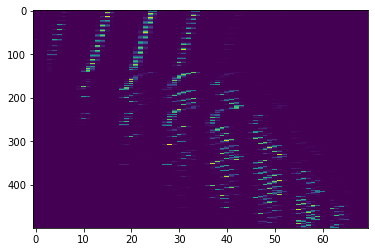

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.ion()
plt.imshow(M,interpolation='none', aspect='auto')

In [17]:
M[76,0] # impacto del beamlet 0 en el voxels 76

0.00211954

In [18]:
np.argsort(-M[:,0])[0:20] #voxels más impactado por beamlet 0

array([55, 67, 22, 44, 33, 68, 56, 91, 45, 23, 34, 57, 46, 80, 69, 13, 24,
       35, 92, 81], dtype=int64)

In [19]:
np.argsort(-M[76,:])[0:20] #beamlets con mayor impacto en voxel 76

array([22, 31, 23, 32, 30, 21, 13, 14, 24, 39, 12, 15, 50, 34, 25, 11, 43,
       52,  7, 26], dtype=int64)